In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
os.chdir("..")

In [3]:
colormap = sns.color_palette("PuOr", 10)

### Read and display the data

In [4]:
def read_data():
    filename = 'data/pima-indians-diabetes.csv'
    dataset = pd.read_csv(filename, header=None)
    dataset.columns = [
        "NumTimesPrg", "PlGlcConc", "BloodP",
        "SkinThick", "TwoHourSerIns", "BMI",
        "DiPedFunc", "Age", "HasDiabetes"]

    return dataset

In [5]:
data = read_data()
data.head()

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
print(data.shape)

(768, 9)


### Train Simple NN on this dataset and measure accuracy

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, n_input, n_hidden=[20,20], n_output=1):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden[0])
        self.hidden2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.output = nn.Linear(n_hidden[1], n_output)
        
    def forward(self, x):
        """ Accepts input of shape (N_objects, n_input) """
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.output(x)
        x = F.sigmoid(x)
        return x

In [8]:
# Example of applying classifier to very simple object
classifier = SimpleNN(8)
x = torch.from_numpy(np.array([data.values[1][:8]], dtype=np.float32))
output = classifier(x)
output > 0.5

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0]], dtype=torch.uint8)

In [9]:
# Divide dataset into training, validation and test datasets
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)
train_data.head()

X_train, y_train = np.array(train_data.values[:, :8], dtype=np.float32), np.array(train_data.values[:, 8], dtype=np.float32)
X_val, y_val = np.array(val_data.values[:, :8], dtype=np.float32), np.array(val_data.values[:, 8], dtype=np.float32)
X_test, y_test = np.array(test_data.values[:, :8], dtype=np.float32), np.array(test_data.values[:, 8], dtype=np.float32)

mean, std = X_train.mean(axis=0), X_train.std(axis=0)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

X_train, X_val, X_test = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(X_test)
y_train, y_val, y_test = torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(y_test)

print(X_train)

tensor([[ 1.2099, -1.1211, -0.7194,  ..., -0.9851, -1.0339,  0.7167],
        [ 0.9133,  0.6859, -0.4648,  ..., -0.4163,  0.6919,  2.3229],
        [ 2.6928, -1.4064, -0.4648,  ...,  0.1008, -0.8960,  0.6322],
        ...,
        [ 0.6167,  0.1469,  0.3498,  ...,  0.2301, -1.0808,  1.7311],
        [ 0.6167,  1.3199, -0.3630,  ..., -0.9981, -0.9023,  1.3930],
        [-0.8662,  1.9222,  0.4516,  ...,  1.0317,  2.4803, -0.9739]])


In [10]:
# Train SimpleNN
model = SimpleNN(8)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=3e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=1e-2)
loss = nn.BCELoss()

n_epochs = 6000
for epoch in range(n_epochs):
    model.zero_grad()
    output = model(X_train)
    cost = loss(output, y_train)
    cost.backward()
    optimizer.step()
    if epoch % 100 == 0:
        val_output = model(X_val)
        val_loss = loss(val_output, y_val)
        val_acc = np.mean((val_output >= 0.5).view(-1).numpy() == y_val.numpy())
        print(f"Cost: {cost.item()}, val_loss: {val_loss.item()}, val_acc: {val_acc}")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([491])) that is different to the input size (torch.Size([491, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([123])) that is different to the input size (torch.Size([123, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Cost: 0.6691176891326904, val_loss: 0.6708135604858398, val_acc: 0.6422764227642277
Cost: 0.6161255836486816, val_loss: 0.6322367191314697, val_acc: 0.6341463414634146
Cost: 0.5683063864707947, val_loss: 0.5969445705413818, val_acc: 0.6991869918699187
Cost: 0.5161466002464294, val_loss: 0.564899206161499, val_acc: 0.7154471544715447
Cost: 0.48257020115852356, val_loss: 0.550054132938385, val_acc: 0.7235772357723578
Cost: 0.46648970246315, val_loss: 0.5453090071678162, val_acc: 0.7317073170731707
Cost: 0.45838993787765503, val_loss: 0.5450062155723572, val_acc: 0.7073170731707317
Cost: 0.4536377787590027, val_loss: 0.5461578965187073, val_acc: 0.6991869918699187
Cost: 0.4505539834499359, val_loss: 0.547372043132782, val_acc: 0.6991869918699187
Cost: 0.4479854106903076, val_loss: 0.5482552647590637, val_acc: 0.6991869918699187
Cost: 0.4460180699825287, val_loss: 0.5479878187179565, val_acc: 0.6991869918699187
Cost: 0.4442637860774994, val_loss: 0.5478164553642273, val_acc: 0.707317073170

In [11]:
test_output = model(X_test)
test_acc = np.mean((test_output >= 0.5).view(-1).numpy() == y_test.numpy())
print(f"Accuracy on test dataset: {test_acc}")

Accuracy on test dataset: 0.7532467532467533


Accuracy on test dataset ~80.5%, which is pretty good, now we can use this model

### Generate set of counterfactuals

In [12]:
from mlexplain.sce.util import choose_k_top_elements_flat

In [13]:
# Choose 10 objects and display them
X_has_diabetes = choose_k_top_elements_flat(model, X_train, K=10)
print(X_has_diabetes)
print(model(X_has_diabetes))

tensor([[-1.1628,  1.8905,  0.4516,  2.7262, -0.5579,  3.5398,  6.1198, -0.7203],
        [-0.8662,  2.4928,  0.3498,  1.4576, -0.6865,  1.4066,  2.9063, -0.9739],
        [ 1.2099,  2.4294,  0.2479, -1.2699, -0.6865, -0.7912,  2.2705,  0.4631],
        [ 0.6167,  2.3660,  0.0443, -1.2699, -0.6865, -0.1448, -0.4325, -0.2131],
        [-1.1628,  1.8588,  1.0625,  0.4427, -0.6865,  1.5617,  0.6888, -0.8894],
        [ 0.9133,  2.3343, -0.0575,  0.5061, -0.6865,  0.5016,  0.8736,  0.6322],
        [ 1.8031,  1.5101,  0.2479, -1.2699, -0.6865,  0.7731,  0.2221,  0.0405],
        [-1.1628,  1.3199,  0.3498,  2.2822,  0.2319,  2.7382,  0.9174, -0.7203],
        [-1.1628,  0.5274, -1.4831,  0.9502,  0.8564,  1.4325,  5.7064, -0.0441],
        [ 0.0236,  1.6052,  0.1461, -1.2699, -0.6865,  1.4971,  0.0404, -0.6358]])
tensor([[0.9846],
        [0.9605],
        [0.9222],
        [0.9114],
        [0.9054],
        [0.9008],
        [0.9000],
        [0.8991],
        [0.8961],
        [0.8951]]

In [14]:
from mlexplain.sce.tabular_sce import TabularSCE

#### Experiment 1. LR=0.1, lambda_coef=0, mu_coef=0

In [15]:
sce = TabularSCE(model, target_class=1)

In [16]:
sce.fit(X_has_diabetes, lambda_coef=0.0, mu_coef=0.0, n_iter=5000, verbose_every_iterations=200, lr=0.1, force_masks_init=False)

[0/5000] Cost: 0.9175159335136414 [0.9175159335136414, 0.0, 0.0]
[200/5000] Cost: 0.9053047299385071 [0.9053047299385071, 0.0, 0.0]
[400/5000] Cost: 0.8889344930648804 [0.8889344930648804, 0.0, 0.0]
[600/5000] Cost: 0.8662219047546387 [0.8662219047546387, 0.0, 0.0]
[800/5000] Cost: 0.8245075345039368 [0.8245075345039368, 0.0, 0.0]
[1000/5000] Cost: 0.7430582046508789 [0.7430582046508789, 0.0, 0.0]
[1200/5000] Cost: 0.5599300861358643 [0.5599300861358643, 0.0, 0.0]
[1400/5000] Cost: 0.3511885404586792 [0.3511885404586792, 0.0, 0.0]
[1600/5000] Cost: 0.29073911905288696 [0.29073911905288696, 0.0, 0.0]
[1800/5000] Cost: 0.26542383432388306 [0.26542383432388306, 0.0, 0.0]
[2000/5000] Cost: 0.254347026348114 [0.254347026348114, 0.0, 0.0]
[2200/5000] Cost: 0.2462676763534546 [0.2462676763534546, 0.0, 0.0]
[2400/5000] Cost: 0.23887500166893005 [0.23887500166893005, 0.0, 0.0]
[2600/5000] Cost: 0.23210032284259796 [0.23210032284259796, 0.0, 0.0]
[2800/5000] Cost: 0.22603079676628113 [0.22603079

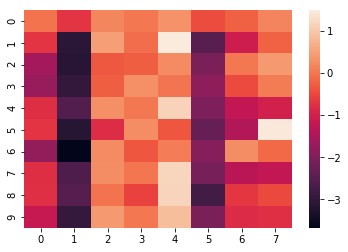

In [17]:
ax1 = sns.heatmap(sce.masks.detach().numpy())

#### Experiment 2. LR=0.1, lambda_coef=0.05, mu_coef=0

In [85]:
sce2 = TabularSCE(model, target_class=1)

In [88]:
sce2.fit(X_has_diabetes, lambda_coef=0.01, mu_coef=0.0, lr=0.1, n_iter=5000, verbose_every_iterations=200, force_masks_init=False)

[0/5000] Cost: 0.7792090177536011 [0.7714269161224365, 0.007782115135341883, 0.0]
[200/5000] Cost: 0.7748969793319702 [0.765720009803772, 0.009176953695714474, 0.0]
[400/5000] Cost: 0.7692803740501404 [0.7586098313331604, 0.01067054271697998, 0.0]
[600/5000] Cost: 0.7392069101333618 [0.7259253859519958, 0.013281512074172497, 0.0]
[800/5000] Cost: 0.6798842549324036 [0.6626378297805786, 0.0172464270144701, 0.0]
[1000/5000] Cost: 0.62308669090271 [0.6019671559333801, 0.021119531244039536, 0.0]
[1200/5000] Cost: 0.5969282388687134 [0.5730122327804565, 0.023916013538837433, 0.0]
[1400/5000] Cost: 0.5797852277755737 [0.5535958409309387, 0.02618936263024807, 0.0]
[1600/5000] Cost: 0.5303657054901123 [0.5012701749801636, 0.029095541685819626, 0.0]
[1800/5000] Cost: 0.516245424747467 [0.4852145314216614, 0.03103088028728962, 0.0]
[2000/5000] Cost: 0.49688273668289185 [0.4634515345096588, 0.033431198447942734, 0.0]
[2200/5000] Cost: 0.45836207270622253 [0.42205318808555603, 0.0363088920712471, 

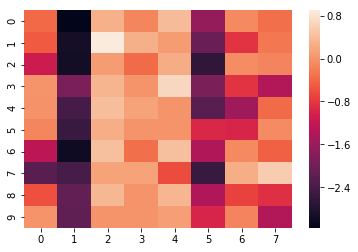

In [97]:
ax2 = sns.heatmap(sce2.masks.detach().numpy())

#### Experiment 3. LR=0.1, lambda_coef=0.03, mu_coef=0.2

In [18]:
sce3 = TabularSCE(model, target_class=1)

In [19]:
sce3.fit(X_has_diabetes, lambda_coef=0.03, mu_coef=0.2, lr=0.1, n_iter=6000, verbose_every_iterations=300, force_masks_init=False)

[0/6000] Cost: 0.9175159335136414 [0.9175159335136414, 0.0, 0.0]
[300/6000] Cost: 0.916333019733429 [0.9134272336959839, 0.0023708019871264696, 0.0005349928396753967]
[600/6000] Cost: 0.9140706658363342 [0.9087464213371277, 0.004819533322006464, 0.0005047490703873336]
[900/6000] Cost: 0.9112140536308289 [0.9031544923782349, 0.007571040652692318, 0.0004885208327323198]
[1200/6000] Cost: 0.9077053070068359 [0.8965463638305664, 0.010667521506547928, 0.0004914525197818875]
[1500/6000] Cost: 0.9033157825469971 [0.8885287046432495, 0.0142818046733737, 0.0005052657215856016]
[1800/6000] Cost: 0.8976569175720215 [0.878674328327179, 0.018503645434975624, 0.00047889864072203636]
[2100/6000] Cost: 0.8902493715286255 [0.8660728335380554, 0.023681221529841423, 0.0004953088937327266]
[2400/6000] Cost: 0.8792386651039124 [0.8485807180404663, 0.030164586380124092, 0.0004933374584652483]
[2700/6000] Cost: 0.8630397319793701 [0.8240658640861511, 0.03848288208246231, 0.0004909757990390062]
[3000/6000] Co

tensor([1, 5, 0, 7, 3, 2, 6, 4])

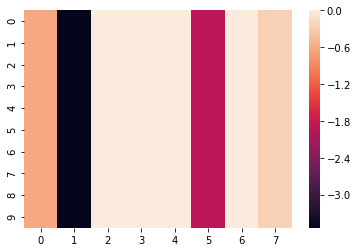

In [20]:
ax3 = sns.heatmap(sce3.masks.detach().numpy())
sce3.top_k_features(descending=False)

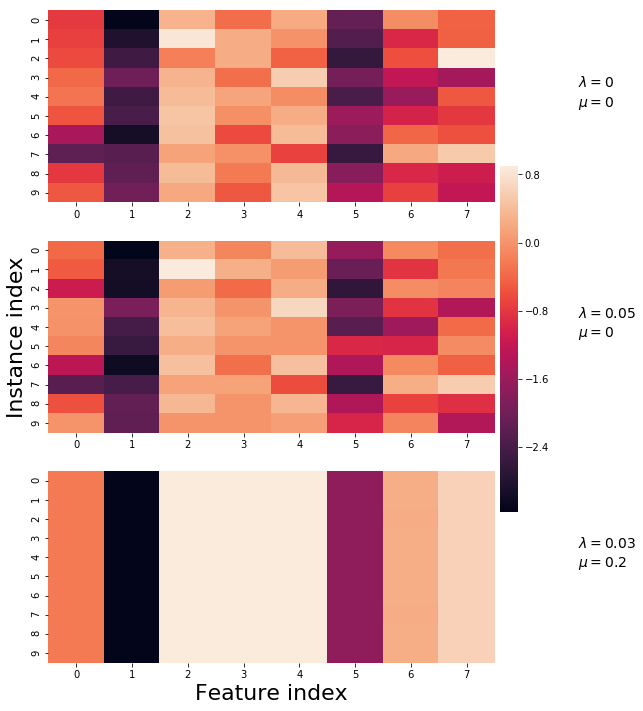

In [165]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(sce.masks.detach().numpy(), ax=axes[0], cbar=False)
sns.heatmap(sce2.masks.detach().numpy(), ax=axes[1], cbar=True, cbar_ax=cbar_ax)
sns.heatmap(sce3.masks.detach().numpy(), ax=axes[2], cbar=False)
axes[2].set_xlabel('Feature index', fontsize=22)
axes[1].set_ylabel('Instance index', fontsize=22)

axes[0].text(9.5, 4, '$\lambda=0$', fontsize=14)
axes[0].text(9.5, 5, '$\mu=0$', fontsize=14)

axes[1].text(9.5, 4, '$\lambda=0.05$', fontsize=14)
axes[1].text(9.5, 5, '$\mu=0$', fontsize=14)

axes[2].text(9.5, 4, '$\lambda=0.03$', fontsize=14)
axes[2].text(9.5, 5, '$\mu=0.2$', fontsize=14)

fig.savefig('experiments/results/pima_experiment_hyperparams_sensitivity.png', bbox_inches="tight")

### sce vs sce3 visualization

In [99]:
import matplotlib.patches as mpatches

In [27]:
feature1 = 1
feature2 = 5
masks1 = sce.masks[:, [feature1, feature2]].detach().numpy()
masks3 = sce3.masks[:, [feature1, feature2]].detach().numpy()
X_has_diabetes_subset = X_has_diabetes[:, [1, feature2]].numpy()
X_test_subset = X_test[:, [feature1, feature2]].numpy()
y_test_subset = y_test.detach().numpy().astype(int)

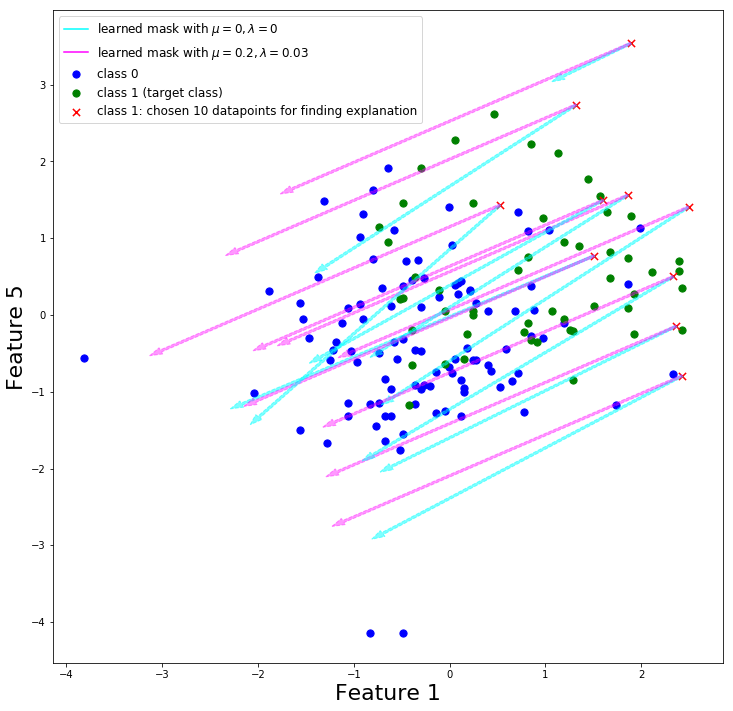

In [127]:
plt.figure(figsize=(12, 12))
plt.scatter(X_test_subset[y_test_subset == 0][:, 0], X_test_subset[y_test_subset == 0][:, 1], c='blue', label='class 0', s=52)
plt.scatter(X_test_subset[y_test_subset == 1][:, 0], X_test_subset[y_test_subset == 1][:, 1], c='green', label='class 1 (target class)', s=52)
plt.scatter(X_has_diabetes_subset[:, 0], X_has_diabetes_subset[:, 1], c='red', marker='x', label='class 1: chosen 10 datapoints for finding explanation', s=52)

for i in range(X_has_diabetes_subset.shape[0]):
    arrow1 = plt.arrow(X_has_diabetes_subset[i, 0], X_has_diabetes_subset[i, 1], masks1[i, 0], masks1[i, 1], color='cyan', linestyle='--', width=0.03, alpha=0.5)
    arrow3 = plt.arrow(X_has_diabetes_subset[i, 0], X_has_diabetes_subset[i, 1], masks3[i, 0], masks3[i, 1], color='magenta', linestyle='--', width=0.03, alpha=0.4)

plt.plot([], [], color='cyan', label='learned mask with $\mu=0, \lambda=0$')
plt.plot([], [], color='magenta', label='learned mask with $\mu=0.2, \lambda=0.03$')

plt.legend(fontsize=12)
plt.xlabel(f'Feature {feature1}', fontsize=22)
plt.ylabel(f'Feature {feature2}', fontsize=22)

fig.savefig('experiments/results/pima_features_15_visualization.png', bbox_inches="tight")

#### Experiment 4. LR=0.1, lambda_coef=0.1, mu_coef=0.2

In [195]:
def fit_lambdas(sce, X, lambda_coefs, mu_coef, lr=0.1, n_iter=2000, verbose_every_iterations=300, force_masks_init=True):
    for lambda_coef in lambda_coefs:
        print(f"Current lambda: {lambda_coef}")
        sce.fit(X, lambda_coef=lambda_coef, mu_coef=mu_coef, 
                lr=lr, n_iter=n_iter // len(lambda_coefs), 
                verbose_every_iterations=verbose_every_iterations,
                force_masks_init=force_masks_init)

In [196]:
sce4 = TabularSCE(model, target_class=1)

In [197]:
fit_lambdas(sce4, X_has_diabetes, lambda_coefs=[0, 0.005, 0.01, 0.03, 0.05, 0.1], mu_coef=0.2, lr=0.1, n_iter=10000, verbose_every_iterations=500, force_masks_init=False)

Current lambda: 0
[0/1666] Cost: 0.9526710510253906 [0.9526710510253906, 0.0, 0.0]
[500/1666] Cost: 0.9331716299057007 [0.9327369928359985, 0.0, 0.00043462516623549163]
[1000/1666] Cost: 0.8198243379592896 [0.819287121295929, 0.0, 0.0005372312152758241]
[1500/1666] Cost: 0.2088804841041565 [0.20814283192157745, 0.0, 0.0007376547437161207]
Current lambda: 0.005
[0/1666] Cost: 0.16575987637043 [0.13330546021461487, 0.032008152455091476, 0.00044625933514907956]
[500/1666] Cost: 0.11458822339773178 [0.07626621425151825, 0.037877157330513, 0.00044485085527412593]
[1000/1666] Cost: 0.09933358430862427 [0.05748409777879715, 0.04140055552124977, 0.00044892611913383007]
[1500/1666] Cost: 0.09205237030982971 [0.0478646382689476, 0.04374786093831062, 0.0004398668825160712]
Current lambda: 0.01
[0/1666] Cost: 0.1332104206085205 [0.04330780357122421, 0.08946123719215393, 0.0004413739370647818]
[500/1666] Cost: 0.12927468121051788 [0.03635546565055847, 0.09247604757547379, 0.0004431710112839937]
[10

In [213]:
sce4.fit(X_has_diabetes, lambda_coef=0.1, mu_coef=0.2, lr=0.1, n_iter=2000, verbose_every_iterations=500, force_masks_init=False)

[0/2000] Cost: 0.6480886936187744 [0.2078293263912201, 0.4395788311958313, 0.000680552504491061]
[500/2000] Cost: 0.6480820775032043 [0.20793528854846954, 0.43945690989494324, 0.0006898754509165883]
[1000/2000] Cost: 0.6478320956230164 [0.21058258414268494, 0.4365595877170563, 0.0006899174768477678]
[1500/2000] Cost: 0.6474446058273315 [0.21733491122722626, 0.42938968539237976, 0.0007200388936325908]


tensor([1, 5, 0, 6, 7, 3, 4, 2])

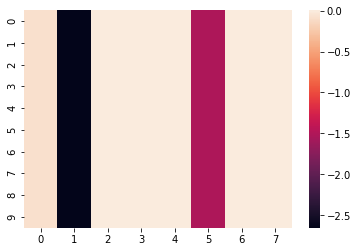

In [214]:
ax4 = sns.heatmap(sce4.masks.detach().numpy())
sce4.top_k_features(descending=False)

We reduced probability even more down to $21.7\%$ by changing 2 features: $1$ and $5$.

#### Experiment 5. LR=0.1, lambda_coef=0.2, mu_coef=0.2

In [202]:
sce5 = TabularSCE(model, target_class=1)

In [204]:
fit_lambdas(sce5, X_has_diabetes, lambda_coefs=[0, 0.005, 0.01, 0.03, 0.05, 0.1, 0.2], mu_coef=0.2, lr=0.1, n_iter=14000, verbose_every_iterations=500, force_masks_init=False)

Current lambda: 0
[0/2000] Cost: 0.18213990330696106 [0.18165627121925354, 0.0, 0.0004836246953345835]
[500/2000] Cost: 0.08208897709846497 [0.08165101706981659, 0.0, 0.0004379563615657389]
[1000/2000] Cost: 0.05708318203687668 [0.05664404109120369, 0.0, 0.00043914132402278483]
[1500/2000] Cost: 0.042263876646757126 [0.041819922626018524, 0.0, 0.0004439526819624007]
Current lambda: 0.005
[0/2000] Cost: 0.07917781174182892 [0.030219685286283493, 0.04852135106921196, 0.0004367716610431671]
[500/2000] Cost: 0.0757911279797554 [0.02527199126780033, 0.05007652938365936, 0.00044261134462431073]
[1000/2000] Cost: 0.0735674574971199 [0.0218362919986248, 0.05128876119852066, 0.0004424116632435471]
[1500/2000] Cost: 0.07194618880748749 [0.019223615527153015, 0.05227810889482498, 0.000444467383204028]
Current lambda: 0.01
[0/2000] Cost: 0.12386515736579895 [0.017281372100114822, 0.10613922774791718, 0.0004445636586751789]
[500/2000] Cost: 0.12330520153045654 [0.017298974096775055, 0.1055621430277

In [207]:
sce5.fit(X_has_diabetes, lambda_coef=0.2, mu_coef=0.2, lr=0.1, n_iter=4000, verbose_every_iterations=300, force_masks_init=False)

[0/2000] Cost: 0.9818410873413086 [0.4196106791496277, 0.5609590411186218, 0.0012713698670268059]
[300/2000] Cost: 0.9793158769607544 [0.4238496422767639, 0.5543880462646484, 0.001078173634596169]
[600/2000] Cost: 0.9793404340744019 [0.4197083115577698, 0.5584589838981628, 0.0011731622507795691]
[900/2000] Cost: 0.979489803314209 [0.4165857434272766, 0.5616845488548279, 0.0012194843729957938]
[1200/2000] Cost: 0.9792008996009827 [0.4141612648963928, 0.5638212561607361, 0.0012183659709990025]
[1500/2000] Cost: 0.9790831208229065 [0.4122585356235504, 0.5657078623771667, 0.001116664963774383]
[1800/2000] Cost: 0.9793399572372437 [0.4101867079734802, 0.5680527091026306, 0.0011005691485479474]


tensor([1, 6, 5, 7, 0, 4, 2, 3])

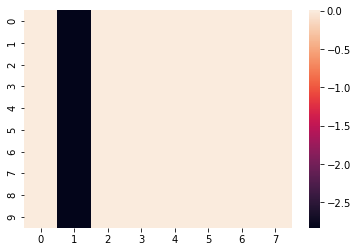

In [208]:
sns.heatmap(sce5.masks.detach().numpy())
sce5.top_k_features(descending=False)

So, we reduced probability from $97\%$ to $41\%$ by just changing $1$ feature. 

#### Experiment 6. LR=0.1, lambda_coef=0.05, mu_coef=0.2

In [215]:
sce6 = TabularSCE(model, target_class=1)

In [216]:
fit_lambdas(sce6, X_has_diabetes, lambda_coefs=[0, 0.005, 0.01, 0.03, 0.05], mu_coef=0.2, lr=0.1, n_iter=10000, verbose_every_iterations=500, force_masks_init=False)

Current lambda: 0
[0/2000] Cost: 0.9526710510253906 [0.9526710510253906, 0.0, 0.0]
[500/2000] Cost: 0.9331716299057007 [0.9327369928359985, 0.0, 0.0004346277564764023]
[1000/2000] Cost: 0.8198243975639343 [0.8192871809005737, 0.0, 0.0005372296436689794]
[1500/2000] Cost: 0.2088804990053177 [0.20814283192157745, 0.0, 0.0007376602734439075]
Current lambda: 0.005
[0/2000] Cost: 0.12187688797712326 [0.08466856181621552, 0.03676615282893181, 0.00044216957758180797]
[500/2000] Cost: 0.10173480212688446 [0.060571908950805664, 0.04071944206953049, 0.0004434480797499418]
[1000/2000] Cost: 0.09443161636590958 [0.0508890263736248, 0.043096721172332764, 0.00044586771400645375]
[1500/2000] Cost: 0.08510524034500122 [0.03886006399989128, 0.04580296576023102, 0.0004422039201017469]
Current lambda: 0.01
[0/2000] Cost: 0.1271543800830841 [0.03086731769144535, 0.09584502875804901, 0.0004420281038619578]
[500/2000] Cost: 0.125595360994339 [0.02789340354502201, 0.09725931286811829, 0.00044263782911002636]

In [219]:
sce6.fit(X_has_diabetes, lambda_coef=0.05, mu_coef=0.2, lr=0.1, n_iter=4000, verbose_every_iterations=300, force_masks_init=False)

[0/4000] Cost: 0.48355212807655334 [0.13058532774448395, 0.2459808588027954, 0.10698596388101578]
[300/4000] Cost: 0.4071550965309143 [0.14954710006713867, 0.2571035921573639, 0.0005044021527282894]
[600/4000] Cost: 0.4012332260608673 [0.1335238218307495, 0.2671853005886078, 0.0005241153994575143]
[900/4000] Cost: 0.3990947902202606 [0.12676355242729187, 0.27181822061538696, 0.0005130231729708612]
[1200/4000] Cost: 0.3975110352039337 [0.12237651646137238, 0.27460482716560364, 0.0005296888411976397]
[1500/4000] Cost: 0.3961300551891327 [0.11933249235153198, 0.2762678563594818, 0.0005296921008266509]
[1800/4000] Cost: 0.3951197564601898 [0.11756817996501923, 0.2770381569862366, 0.0005134038510732353]
[2100/4000] Cost: 0.3947167694568634 [0.11761623620986938, 0.2765699028968811, 0.0005306341918185353]
[2400/4000] Cost: 0.39428144693374634 [0.11758597195148468, 0.2761729061603546, 0.0005225656786933541]
[2700/4000] Cost: 0.39417678117752075 [0.11676327884197235, 0.2768382430076599, 0.00057

tensor([1, 5, 0, 6, 7, 3, 2, 4])

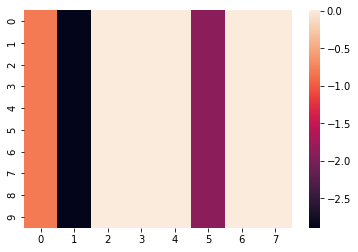

In [220]:
sns.heatmap(sce6.masks.detach().numpy())
sce6.top_k_features(descending=False)

Probability reduced down to $11\%$ just by changing 3 features $1, 5, 0$. 

#### Experiment 7. LR=0.1, lambda_coef=0.02, mu_coef=0.2

In [221]:
sce7 = TabularSCE(model, target_class=1)

In [222]:
fit_lambdas(sce7, X_has_diabetes, lambda_coefs=[0, 0.005, 0.01, 0.02], mu_coef=0.2, lr=0.1, n_iter=8000, verbose_every_iterations=500, force_masks_init=False)

Current lambda: 0
[0/2000] Cost: 0.9526710510253906 [0.9526710510253906, 0.0, 0.0]
[500/2000] Cost: 0.9331716299057007 [0.9327369928359985, 0.0, 0.0004346262139733881]
[1000/2000] Cost: 0.8198243379592896 [0.819287121295929, 0.0, 0.0005372315063141286]
[1500/2000] Cost: 0.2088804543018341 [0.20814278721809387, 0.0, 0.0007376683643087745]
Current lambda: 0.005
[0/2000] Cost: 0.12187691032886505 [0.08466854691505432, 0.03676615282893181, 0.00044221020652912557]
[500/2000] Cost: 0.10173442959785461 [0.060571394860744476, 0.04071957617998123, 0.00044345870264805853]
[1000/2000] Cost: 0.09443147480487823 [0.05088876560330391, 0.043096818029880524, 0.00044588930904865265]
[1500/2000] Cost: 0.08510522544384003 [0.03885997086763382, 0.045803043991327286, 0.00044221055577509105]
Current lambda: 0.01
[0/2000] Cost: 0.12715445458889008 [0.030867282301187515, 0.09584517031908035, 0.0004419954202603549]
[500/2000] Cost: 0.12559548020362854 [0.027893420308828354, 0.09725942462682724, 0.0004426336090

In [229]:
sce7.fit(X_has_diabetes, lambda_coef=0.02, mu_coef=0.2, lr=0.1, n_iter=4000, verbose_every_iterations=300, force_masks_init=False)

[0/4000] Cost: 0.1937554031610489 [0.030041908845305443, 0.16324801743030548, 0.000465478835394606]
[300/4000] Cost: 0.19361622631549835 [0.029874566942453384, 0.1632748246192932, 0.00046683705295436084]
[600/4000] Cost: 0.1934744268655777 [0.02963664010167122, 0.1633857935667038, 0.00045199599117040634]
[900/4000] Cost: 0.19336016476154327 [0.02941308356821537, 0.16348987817764282, 0.0004571918398141861]
[1200/4000] Cost: 0.193256214261055 [0.029221588745713234, 0.16357122361660004, 0.0004634020442608744]
[1500/4000] Cost: 0.19314764440059662 [0.029070455580949783, 0.1636127233505249, 0.00046447181375697255]
[1800/4000] Cost: 0.19303956627845764 [0.02893386222422123, 0.16363650560379028, 0.00046919682063162327]
[2100/4000] Cost: 0.19292765855789185 [0.02883150801062584, 0.16363097727298737, 0.0004651759227272123]
[2400/4000] Cost: 0.19282053411006927 [0.028723936527967453, 0.16363245248794556, 0.0004641479754354805]
[2700/4000] Cost: 0.19272029399871826 [0.028610747307538986, 0.163639

tensor([1, 7, 5, 0, 3, 6, 2, 4])

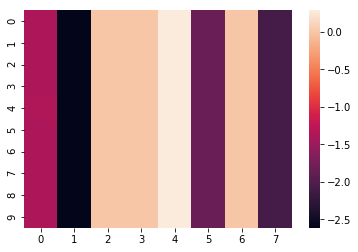

In [230]:
sns.heatmap(sce7.masks.detach().numpy())
sce7.top_k_features(descending=False)

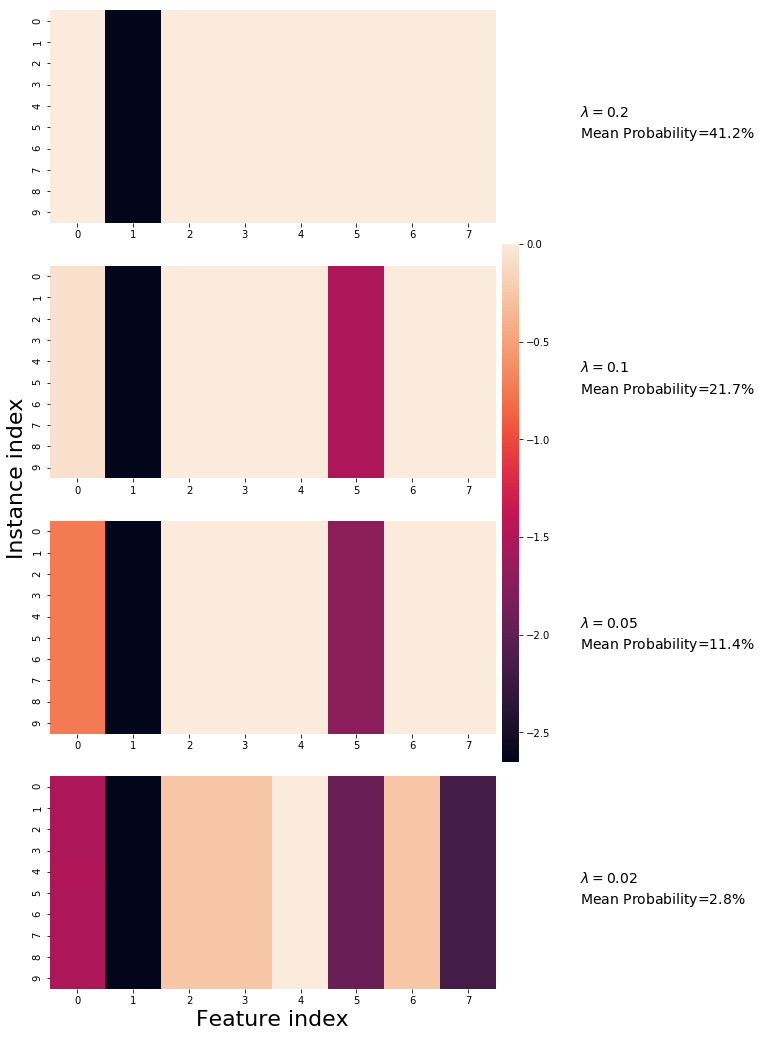

In [267]:
fig, axes = plt.subplots(4, 1, figsize=(8, 18), sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(sce5.masks.detach().numpy(), ax=axes[0], cbar=False)
sns.heatmap(sce4.masks.detach().numpy(), ax=axes[1], cbar=True, cbar_ax=cbar_ax)
sns.heatmap(sce6.masks.detach().numpy(), ax=axes[2], cbar=False)
sns.heatmap(sce7.masks.detach().numpy(), ax=axes[3], cbar=False)

numb_changed_coef = [0, 1, 2, 3, 4]
probs = [95.2, 41.2, 21.7, 11.4, 2.8]

axes[3].set_xlabel('Feature index', fontsize=22)
axes[1].set_ylabel('Instance index', fontsize=22)
axes[1].yaxis.set_label_coords(-0.05, 0)

axes[0].text(9.5, 5, '$\lambda=0.2$', fontsize=14)
axes[0].text(9.5, 6, f'Mean Probability=${probs[1]}\%$', fontsize=14)

axes[1].text(9.5, 5, '$\lambda=0.1$', fontsize=14)
axes[1].text(9.5, 6, f'Mean Probability=${probs[2]}\%$', fontsize=14)

axes[2].text(9.5, 5, '$\lambda=0.05$', fontsize=14)
axes[2].text(9.5, 6, f'Mean Probability=${probs[3]}\%$', fontsize=14)

axes[3].text(9.5, 5, '$\lambda=0.02$', fontsize=14)
axes[3].text(9.5, 6, f'Mean Probability=${probs[4]}\%$', fontsize=14)


fig.savefig('experiments/results/pima_experiment_lambdas_sensitivity.png', bbox_inches="tight")

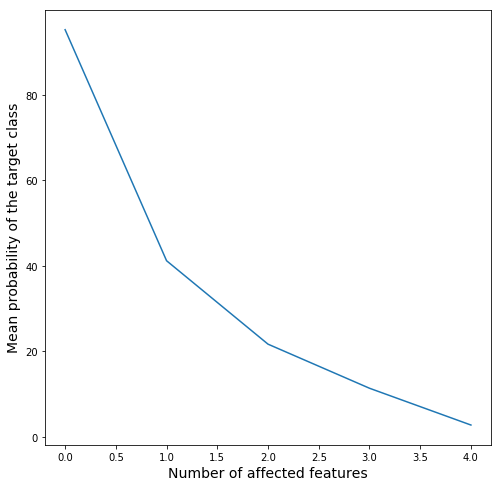

In [275]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plt.plot(numb_changed_coef, probs)
plt.xlabel('Number of affected features', fontsize=14)
plt.ylabel('Mean probability of the target class', fontsize=14)

plt.savefig('experiments/results/pima_mean_prob_affected_features_graph.png', bbox_inches="tight")

#### Experiment 8. Varying number of features input datapoints. LR=0.1, lambda_coef=0.02, mu=0.2

In [38]:
X_has_diabetes_50 = choose_k_top_elements_flat(model, X_train, K=50)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [39]:
print(model(X_has_diabetes_50[-1]))

tensor([0.7672], grad_fn=<SigmoidBackward>)


In [40]:
Ns = [1, 2, 5, 10, 15, 20, 30]
sces8 = []

for N in Ns:
    print(f"Processing N={N}")
    sces8.append(TabularSCE(model, target_class=1))
    sces8[-1].fit(X_has_diabetes_50[:N], lambda_coef=0.02, mu_coef=0.2, lr=0.1, n_iter=10000, verbose_every_iterations=1000, force_masks_init=False)

Processing N=1
[0/10000] Cost: 0.9114959836006165 [0.9114959836006165, 0.0, 0.0]
[1000/10000] Cost: 0.2921053469181061 [0.09224334359169006, 0.19986200332641602, 0.0]
[2000/10000] Cost: 0.2515895366668701 [0.05778130888938904, 0.19380822777748108, 0.0]
[3000/10000] Cost: 0.2401878386735916 [0.05063830688595772, 0.1895495355129242, 0.0]
[4000/10000] Cost: 0.2369837611913681 [0.05159332975745201, 0.1853904277086258, 0.0]
[5000/10000] Cost: 0.22362898290157318 [0.043162137269973755, 0.18046684563159943, 0.0]
[6000/10000] Cost: 0.21724507212638855 [0.03661942854523659, 0.18062564730644226, 0.0]
[7000/10000] Cost: 0.20966312289237976 [0.03525848314166069, 0.17440463602542877, 0.0]
[8000/10000] Cost: 0.20186004042625427 [0.03430430591106415, 0.16755573451519012, 0.0]
[9000/10000] Cost: 0.18907025456428528 [0.03240686282515526, 0.15666338801383972, 0.0]
Processing N=2
[0/10000] Cost: 0.9100562334060669 [0.9100562334060669, 0.0, 0.0]
[1000/10000] Cost: 0.464193731546402 [0.34529709815979004, 0

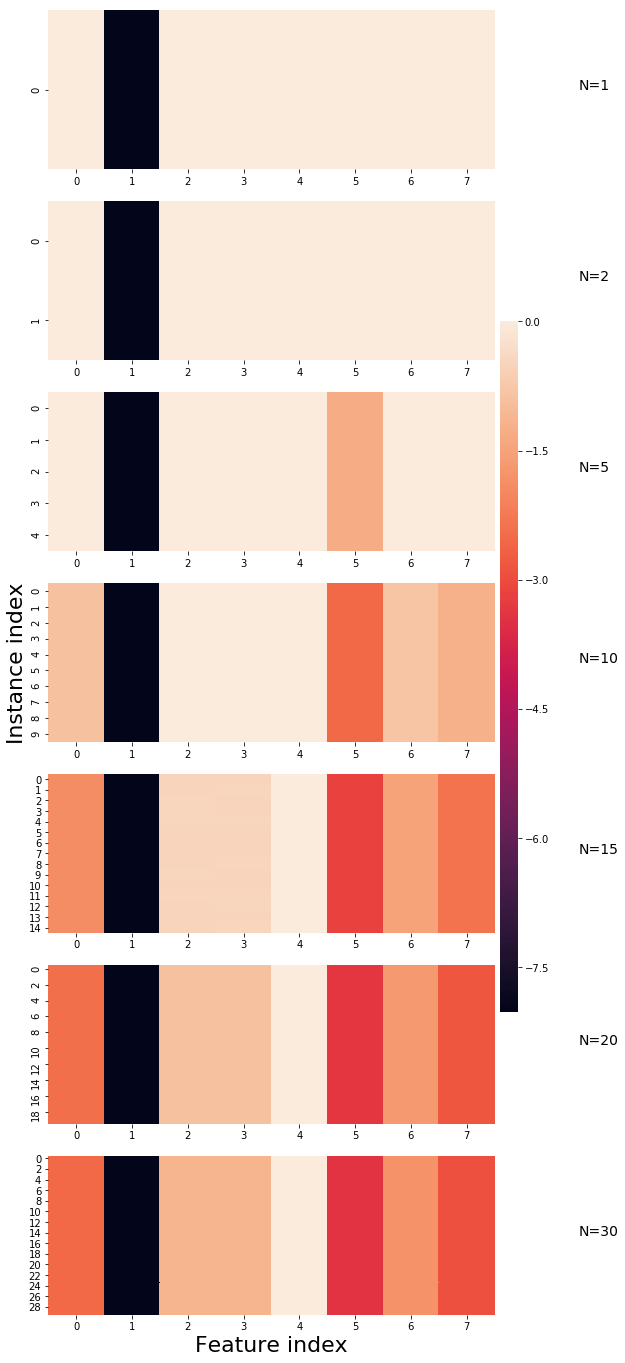

In [43]:
fig, axes = plt.subplots(len(sces8), 1, figsize = (8, 24))

cbar_ax = fig.add_axes([.91, .3, .03, .4])
for idx, sce in enumerate(sces8):
    sns.heatmap(sce.masks.detach().numpy(), ax=axes[idx], cbar = (idx == 0), cbar_ax = cbar_ax if idx == 0 else None)
    axes[idx].text(9.5, Ns[idx] / 2, f'N={Ns[idx]}', fontsize=14)

axes[3].set_ylabel('Instance index', fontsize=22)
axes[-1].set_xlabel('Feature index', fontsize=22)
fig.savefig('experiments/results/pima_experiment_N_sensitivity.png', bbox_inches="tight")